# Linear Regression
Using linear regression, the critical temperatures of superconductors were predict. 
From the type clusters created by the [clustering](https://github.com/fullmetalchem15t/superconductors/blob/master/Superconductor_clustering.ipynb) notebook notebook, 3 models were created. 
One only using data from Label 1, one only using the data from Label 2, and one using all labeled data. 
Seperating the linear regression results were improved by
seperating the data before fitting. The models RMSE was 19.50 K without seperating and 17.36 K when seperated.

In [4]:
import numpy as np
import pandas as pd

#regular expression
import re

#visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.rcParams.update({'font.size': 20})

#machine learn algrothism 
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  mean_squared_error
from sklearn.pipeline import Pipeline
#from sklearn.model_selection import cross_val_score

#for statistics
from scipy import stats

#for debugging
import pdb

#Do not display warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans  
#from hdbscan import HDBSCAN

#dataframes with was initialized in the Superconductor_statistics notebook
from ipynb.fs.defs.Superconductor_statistics import InitializeDataframes
#clustering algorithm Superconductor_clustering notebook
from ipynb.fs.defs.Superconductor_clustering import KMeanTypeI_II


## Initializing data and seperating into clusters.

See [Superconductor_statistics.ipynb](https://github.com/fullmetalchem15t/superconductors/blob/master/Superconductor_statistics.ipynb) for data wrangling details and [Superconductor_clustering.ipynb](https://github.com/fullmetalchem15t/superconductors/blob/master/Superconductor_clustering.ipynb) for  clustering details.

In [6]:
#create orignal dataframe
prop_df,atoms_df,material=InitializeDataframes()
prop_df=KMeanTypeI_II(prop_df)

#create bool label I/II database
label1_bool = prop_df['label'] == 1 

#remove label from dataframe. It is not used by linear model
prop_df.drop(['label'],axis=1,inplace=True)

#label 1
prop_label1 = prop_df[label1_bool]
atoms_label1 = atoms_df[label1_bool]
material_label1 = material[label1_bool]

#label 2
prop_label2 = prop_df[~label1_bool]
atoms_label2 = atoms_df[~label1_bool]
material_label2 = material[~label1_bool]

## Property data split into training set and test set

Using the properties dataframe, three linear models were created. One from the cluster labeled 1, one from the cluster labeled 2, and the with all labeled data. The data from each model is seperated into a training set (to make the model) and a testing set (to test the model), In order to prevent unbalanced data, an equal number of data points from each cluster will be placed into the training set of with all labeled data.

In [7]:
#label1
X_label1 = prop_label1.drop(['critical_temp'],axis=1)
y_label1 = prop_label1['critical_temp']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_label1, y_label1, train_size=7000, random_state=42)

#label2
X_label2 = prop_label2.drop(['critical_temp'],axis=1)
y_label2 = prop_label2['critical_temp']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_label2, y_label2, train_size=7000, random_state=42)

#All labels
X_train = pd.concat([X_train1,X_train2])
X_test = pd.concat([X_test1,X_test2])
y_train = pd.concat([y_train1,y_train2])
y_test = pd.concat([y_test1,y_test2])

# Linear Regression Model

The linear regression model was produced from a least square method. Three models were created, 
one using Label 1 only, and one using Label 2 only, and one using all labeled training data.

We had previously tried regulating the linear regression using the scikit-learns elastic net regularization
method parameterized with gridSearchCV. The RMSE for this method was larger than a simple least square method so it least square method method was used instend.


Results using ElasticNet : 
<br>RMSE = 21.37 K without clustering 
<br>RMSE = 18.53 K with clustering

In [8]:
def LinearFit(X_train, X_test, y_train, y_test):
    #scaling
    scale = StandardScaler()

    #Linear Regression
    lin_reg = LinearRegression()
    #pineline
    pipeline = Pipeline([('scaler',scale),('linear',lin_reg)])
    pipeline.fit(X_train,y_train)
    r2 = pipeline.score(X_test, y_test)
    print("R squared: {}".format(r2))
    return pipeline
    
#     #ElasticNet (regularized linear model) with grid
#     el_net = ElasticNet(random_state=42)
#     #pineline
#     pipeline = Pipeline([('scaler',scale),('elasticnet',el_net)])
#     #Grid search
#     param_grid = {'elasticnet__l1_ratio': np.arange(0.0,1.0,0.1),
#              'elasticnet__alpha': [0.0001,0.001,0.01,0.1,10,100],
#              'elasticnet__max_iter':[1,5,10]}
#     grid_cv = GridSearchCV(pipeline,param_grid=param_grid,cv=5)
#     grid_cv.fit(X_train,y_train)
#     r2 = grid_cv.score(X_test, y_test)
#     print("Tuned ElasticNet Alpha: {}".format(grid_cv.best_params_))
#     print("Tuned ElasticNet R squared: {}".format(r2))
#     return grid_cv

In [9]:
def LinearPredict(X_test,y_test,grid_cv):
    y_predict = grid_cv.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test,y_predict))
    return y_predict,RMSE
    
def GetGridCoeff(grid_cv):
    return grid_cv.best_estimator_.named_steps['elasticnet'].coef_

def GetPipelineCoeff(pipeline):
    return pipeline.named_steps['linear'].coef_

In [22]:
#Get linear_models
linear_prop=LinearFit(X_train, X_test, y_train, y_test)
linear_prop1=LinearFit(X_train1, X_test1, y_train1, y_test1)
linear_prop2=LinearFit(X_train2, X_test2, y_train2, y_test2)

#Get grid_model
#grid_prop=LinearFit(X_train, X_test, y_train, y_test)
#grid_prop1=LinearFit(X_train1, X_test1, y_train1, y_test1)
#grid_prop2=LinearFit(X_train2, X_test2, y_train2, y_test2)

R squared: 0.6959197953481491
R squared: 0.5285382806896044
R squared: 0.6540118112378012


## Get Predicted Values and RMSE Error

The RMSE using all three models is shown below. The prediction of linear regression fitted using all labeled had an RMSE of 19.50 K. When the labeled data was seperated into different gradient boosting model, the RMSE was 17.36 K. Seperating the labeled data therefore did improve linear regression model accuracy.  

In [23]:
#get predicted from regression on entire model 
y_pred,RMSE=LinearPredict(X_test,y_test,linear_prop)
y_pred_data1,RMSE_label1=LinearPredict(X_test1,y_test1,linear_prop)
y_pred_data2,RMSE_label2=LinearPredict(X_test2,y_test2,linear_prop)

#get predicted from regression on seperated labeled data
y_pred_model1,RMSE_model1=LinearPredict(X_test1,y_test1,linear_prop1)
y_pred_model2,RMSE_model2=LinearPredict(X_test2,y_test2,linear_prop2)

#combine the predicted from the two seperated label models 
y_pred_seperated = np.concatenate((y_pred_model1,y_pred_model2))
RMSE_seperated = np.sqrt(mean_squared_error(y_test,y_pred_seperated))

#Get coeffients
coef = GetPipelineCoeff(linear_prop)
coef1 = GetPipelineCoeff(linear_prop1)
coef2 = GetPipelineCoeff(linear_prop2)

#coef = GetGridCoeff(grid_prop)
#coef1 = GetGridCoeff(grid_prop1)
#coef2 = GetGridCoeff(grid_prop2)

In [12]:
print('RMSE from All labeled modeled together')
print('Label One: {:.2f} K'.format(RMSE_label1))
print('Label Two: {:.2f} K'.format(RMSE_label2))
print('All data:{:.2f} K'.format(RMSE))

print('\nRMSE from labeled clusters are modeled seperately')
print('Label One: {:.2f} K'.format(RMSE_model1))
print('Label Two: {:.2f} K'.format(RMSE_model2))
print('All Data: {:.2f} K'.format(RMSE_seperated))


RMSE from All labeled modeled together
Label One: 9.58 K
Label Two: 21.79 K
All data:19.50 K

RMSE from labeled clusters are modeled seperately
Label One: 5.98 K
Label Two: 19.71 K
All Data: 17.36 K


In [40]:
## Important Features

In [37]:
#Get Most important coefficients
coeff_df = pd.DataFrame(data = coef,columns=['coeff'],index=X_train.columns)
coeff_df1= pd.DataFrame(data = coef1,columns=['coeff'],index=X_train.columns)
coeff_df2 = pd.DataFrame(data = coef2,columns=['coeff'],index=X_train.columns)

#Important coefficients to entire model
df_all = coeff_df.iloc[coeff_df['coeff'].abs().argsort()[::-1]].round(2).head(10)
df_all.reset_index(level=0, inplace=True)
df_all.rename(columns={'index':'Feature'},inplace=True)
df_all['Label'] = 'All label'
df_all['Rank'] = range(1,11,1)

#Important coefficients to entire model label 1
df1 = coeff_df1.iloc[coeff_df1['coeff'].abs().argsort()[::-1]].round(2).head(10)
df1.reset_index(level=0, inplace=True)
df1.rename(columns={'index':'Feature'},inplace=True)
df1['Label'] = 'Label 1'
df1['Rank'] = range(1,11,1)

#Important coefficients to entire model label 2
df2 = coeff_df2.iloc[coeff_df2['coeff'].abs().argsort()[::-1]].round(2).head(10)
df2.reset_index(level=0, inplace=True)
df2.rename(columns={'index':'Feature'},inplace=True)
df2['Label'] = 'Label 2'
df2['Rank'] = range(1,11,1)

#combine into one table
df_merged = pd.concat([df_all,df1,df2])
df_merged = df_merged.pivot(index='Rank',columns='Label').swaplevel(i=0, j=1, axis=1)

#reorganizing 
df_multilevel = df_merged.iloc[:,df_merged.columns.get_level_values(0)=='All label']
df1_multilevel = df_merged.iloc[:,df_merged.columns.get_level_values(0)=='Label 1']
df2_multilevel = df_merged.iloc[:,df_merged.columns.get_level_values(0)=='Label 2']
pd.concat([df_multilevel,df1_multilevel,df2_multilevel],axis=1)

Label                     All label                          Label 1         \
                            Feature   coeff                  Feature  coeff   
Rank                                                                          
1           wtd_gmean_atomic_radius -102.69  wtd_gmean_atomic_radius -35.96   
2            wtd_mean_atomic_radius   93.40   wtd_mean_atomic_radius  35.92   
3                       entropy_fie  -46.86    entropy_atomic_radius  29.10   
4                   entropy_Valence   30.91                 mean_fie  19.42   
5             entropy_atomic_radius   28.24                gmean_fie -17.90   
6              std_ElectronAffinity   28.07             wtd_mean_fie -16.72   
7               wtd_mean_FusionHeat  -27.28            wtd_gmean_fie  16.37   
8               wtd_entropy_Valence  -26.57      wtd_mean_FusionHeat -14.11   
9      wtd_mean_ThermalConductivity   25.05          entropy_Valence -13.93   
10             wtd_mean_atomic_mass  -24.61              entropy_fie -12.17   

Label                Label 2          
                     Feature   coeff  
Rank                                  
1               wtd_mean_fie -163.11  
2              wtd_gmean_fie  158.50  
3                entropy_fie -111.55  
4        gmean_atomic_radius  -99.70  
5         mean_atomic_radius   91.50  
6           wtd_mean_Valence   75.95  
7      entropy_atomic_radius   69.66  
8                   mean_fie   69.45  
9                  gmean_fie  -63.35  
10         wtd_gmean_Valence  -61.15

In [14]:
def TempLinearPlot(y_pred1, y_test1,y_pred2, y_test2, axis, plot_title = '',
                   Include_y=True,xlim=[-50,140],ylim=[-50,140]):

    #scatterplot
    #data 2 first so it is on the bottom layer
    p1 = axis.scatter(x=y_test2,y=y_pred2,color='red',alpha=0.2)
    p2 =axis.scatter(x=y_test1,y=y_pred1,color='blue',alpha=0.2)
    plt.legend([p2,p1],['Label 1', 'Label 2'],fontsize=20)
    #line X_test
    x_plot = np.arange(-50,150,1)
    sns.lineplot(x=x_plot,y=x_plot,color='black',ax=axis)
    plt.title(plot_title,fontsize=24)
    #plt.xlim([-50,140])
    #plt.ylim([-50,140]) 
    plt.xticks([-25,0,25,50,75,100,125])
    plt.yticks([-25,0,25,50,75,100,125])
    if Include_y:
        plt.ylabel('Predicted Critical Temperature (K)',fontsize=20)
        plt.yticks([-25,0,25,50,75,100,125])
    else:
        plt.ylabel('')
        plt.yticks([])
    plt.xlabel('Observed Critical Temperature (K)',fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)   
    

    #show root mean square error
    y_test = np.concatenate((y_test1,y_test2))
    y_pred = np.concatenate((y_pred1,y_pred2))
    RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
    text = 'RMSE:' + format(RMSE,'.2f') + ' K' 
    #box_x = x_plot.mean()/2
    #box_y = x_plot.mean()/2
    box_x = 50
    box_y = 75
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
    axis.text(s=text,x=box_x,y=box_y,color='red',bbox=bbox_props,fontsize=20,horizontalalignment='center')

## Linear Regression Predicted vs. Reported Critical Temperature Scatterplots

[]

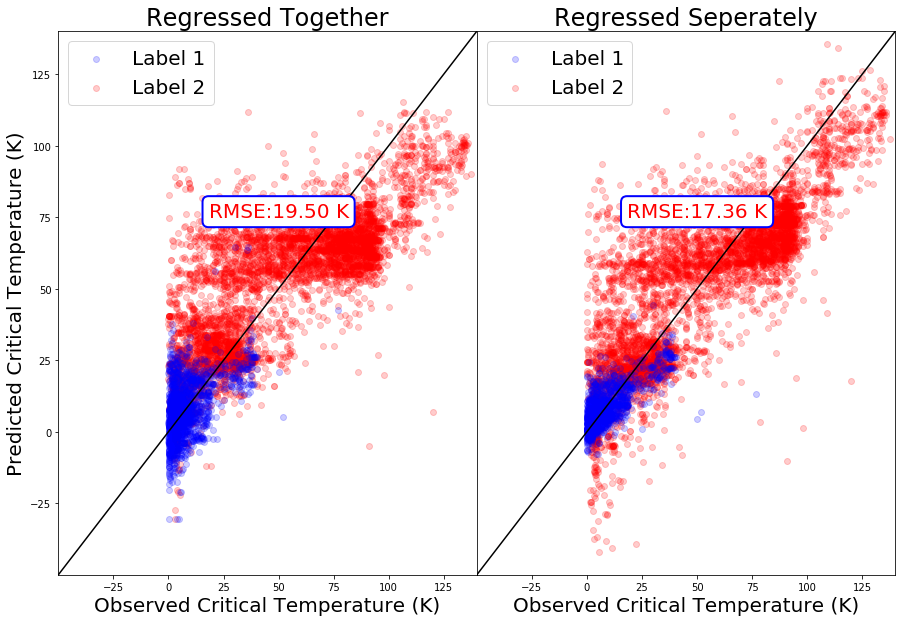

In [15]:
fig = plt.figure(figsize=(15,10)) 
grid = gridspec.GridSpec(1, 2)
grid.update(wspace=0.00, hspace=0.05)
ax1 = plt.subplot(grid[0])
TempLinearPlot(y_pred_data1, y_test1,y_pred_data2,y_test2,ax1,'Regressed Together',True)
plt.subplots_adjust(wspace=None, hspace=None)
ax2 = plt.subplot(grid[1])
#ax2 = fig.add_subplot(1,2,2)
TempLinearPlot(y_pred_model1, y_test1,y_pred_model2,y_test2,ax2,'Regressed Seperately',False)
plt.plot()